In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES']='1'

from matplotlib import pyplot as plt 
import numpy as np
import pickle

import jax
import jax.numpy as jnp
import tqdm
import optax
import flax.linen as nn
from flax.metrics import tensorboard
from jax_resnet import resnet
from functools import partial

import shear2cosmo
import shear2cosmo.datasets
import tensorflow_datasets as tfds

In [2]:
# Define folders
SHEAR2COSMO_dir = '/net/GECO/pisco/SHEAR2COSMO/'
IMAGESIMS_dir = SHEAR2COSMO_dir+'tensorflow_datasets/'
LOGS_dir = SHEAR2COSMO_dir+'logs/'
MODELS_dir = SHEAR2COSMO_dir+'MODELS/'
PLOTS_dir = SHEAR2COSMO_dir+'PLOTS/'

In [3]:
# Define hyperparameters and suffix
batch_size = 32

# Define a scheduler for the learning rate
total_steps = 20_000
lri = 0.002

lr2 = 0.5
step_2 = 10_000

lr_scheduler = optax.piecewise_constant_schedule(init_value=lri,
                  boundaries_and_scales={int(step_2):lr2,})

# Define a simple MSE regression loss 
def loss_fn(params, batch):
    return jnp.mean(jnp.sum((model.apply(params, batch['x']) - batch['y'])**2,axis=-1))

case = 'cosmoslics_resnet18_mse_lri'+str(lri)+'_lr2'+str(lr2)+'_batch'+str(batch_size)+'_steps'+str(total_steps)

In [4]:
# Define our compressor
ResNet = partial(resnet.ResNet18, n_classes=4)

class NeuralCompressor(nn.Module):
  @nn.compact
  def __call__(self, x):
    return ResNet()(x)

In [5]:
# Random seed for sampling from posterior
seed = jax.random.PRNGKey(0)

# Let's instantiate and initialize the model
model = NeuralCompressor()
params = model.init(jax.random.PRNGKey(42), jnp.zeros(shape=[1, 128, 128,1]))

# Initializes an optimizer and optimizer state
optimizer = optax.adam(learning_rate=lr_scheduler)
opt_state = optimizer.init(params)

summary_writer = tensorboard.SummaryWriter(LOGS_dir+case)

2023-09-15 11:20:36.091597: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023-09-15 11:20:42.750616: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [7]:
dset = tfds.load('cosmo_slics',split='train',data_dir=IMAGESIMS_dir)
# Let's collect a few examples to check their distributions
cutouts=[]
specz = []
for (batch, entry) in enumerate(dset.take(100)):
  cutouts.append(entry['Map'])
cutouts = np.stack(cutouts)
cutouts[np.isnan(cutouts)] = 0

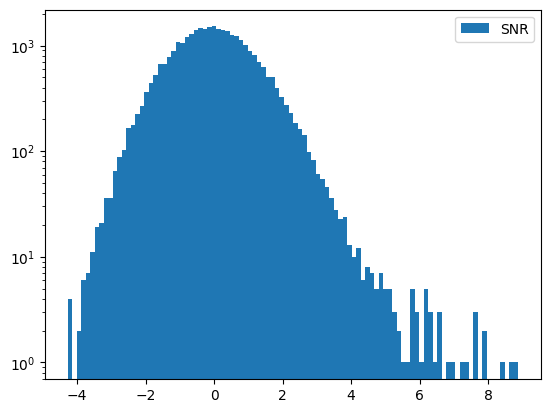

In [15]:
for i,b in enumerate(['SNR']):
  plt.hist(cutouts[...].flatten(),100, label=b);
plt.legend()
plt.yscale('log')

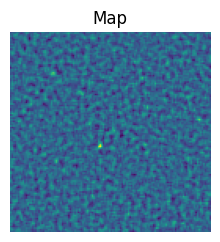

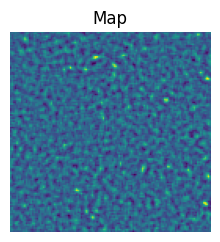

In [16]:
plt.figure(figsize=(15,3))
for i,b in enumerate(['Map']):
  plt.subplot(1,5,i+1)
  plt.imshow(cutouts[0,:,:],vmin=-4,vmax=8)
  plt.title(b)
  plt.axis('off')

plt.figure(figsize=(15,3))
for i,b in enumerate(['Map']):
  plt.subplot(1,5,i+1)
  plt.imshow(cutouts[1,:,:],vmin=-4,vmax=8)
  plt.title(b)
  plt.axis('off')

In [ ]:
#went up to there... rest to be updated.

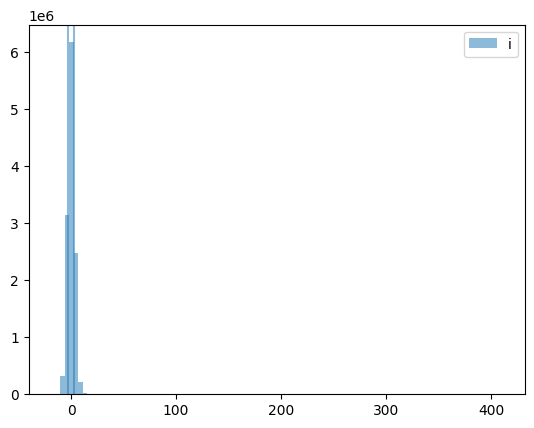

In [10]:
# Let's evaluate the noise standard deviation in each band, and apply range 
# compression accordingly
from astropy.stats import mad_std
scaling = []

for i,b in enumerate(['i']):
  plt.hist(cutouts[...].flatten(),100, label=b,alpha=0.5,);
  sigma = mad_std(cutouts[...].flatten())
  scaling.append(sigma)
  plt.axvline(sigma, color='C%d'%i,alpha=0.5)
  plt.axvline(-sigma, color='C%d'%i,alpha=0.5)
plt.legend()

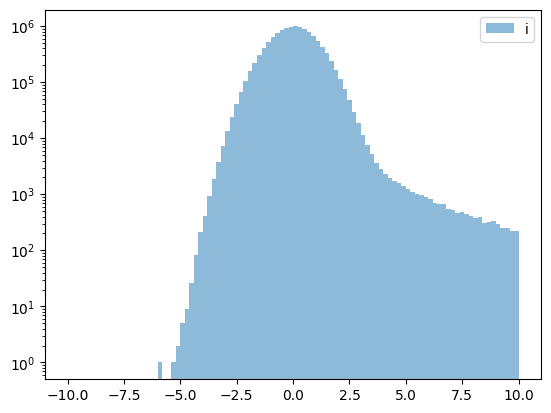

In [11]:
# Let's have a look at this distribution if we rescale each band by the standard
# deviation
for i,b in enumerate([ 'i']):
  plt.hist(cutouts[...].flatten()/scaling[i],100, label=b,alpha=0.5,
           range=[-10,10]);
plt.legend()
plt.yscale('log')

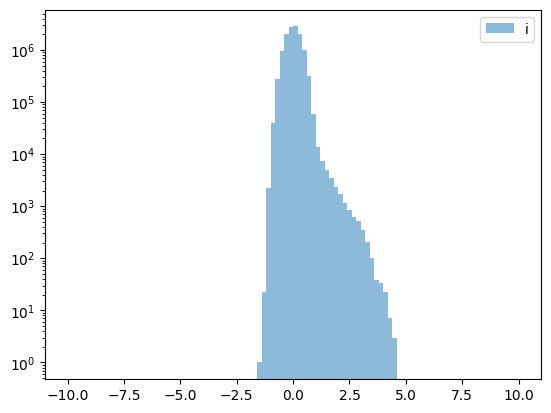

In [12]:
# a common approach for range compression is to apply arcsinh to suppress the
# high amplitude values
for i,b in enumerate(['i']):
  plt.hist(np.arcsinh(cutouts[...].flatten()/scaling[i]/3),100,
           label=b, alpha=0.5,
           range=[-10,10]);
plt.legend()
plt.yscale('log')

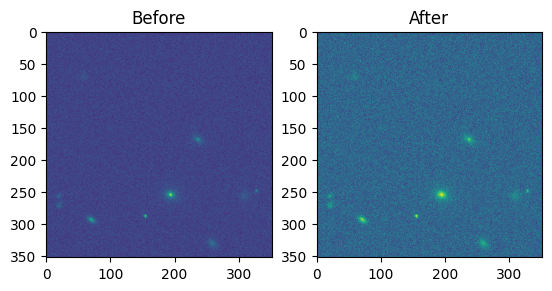

In [13]:
# we can have a look at individual postage stamps with or without this scaling
plt.subplot(121)
plt.imshow(cutouts[0,:,:]/scaling[0])
plt.title('Before')
plt.subplot(122)
plt.imshow(np.arcsinh(cutouts[0,:,:]/scaling[0]/3))
plt.title('After');

In [14]:
import tensorflow as tf
def preprocessing(example):
  def range_compression(img):
    return tf.clip_by_value(tf.math.asinh(tf.expand_dims(img, axis=-1) / tf.constant(scaling) / 3. ),-10,10)
  # Our preprocessing function only returns the postage stamps, and the shear
  return range_compression(example['image']), example['g']

In [15]:
#batch_size = 64

# Load the data
dset = tfds.load('pisco_euclid',split='train[:80%]',data_dir=IMAGESIMS_dir)
dset = dset.repeat()
dset = dset.shuffle(10000)
dset = dset.map(preprocessing)
dset = dset.batch(batch_size, drop_remainder=True)
dset = dset.prefetch(-1)
dset = dset.as_numpy_iterator()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [16]:
dset_val = tfds.load('pisco_euclid',split='train[80%:90%]',data_dir=IMAGESIMS_dir)
dset_val = dset_val.repeat()
dset_val = dset_val.map(preprocessing)
dset_val = dset_val.batch(batch_size, drop_remainder=True)
dset_val = dset_val.prefetch(-1)
dset_val = dset_val.as_numpy_iterator()

In [17]:
@jax.jit
def update_model(params,  opt_state, batch):
  # Computes the gradients of the model
  loss, grads = jax.value_and_grad(loss_fn)(params, batch)

  # Computes the weights updates and apply them
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return params, opt_state, loss

In [18]:
#os.environ['TENSORBOARD_BINARY'] = '/net/GECO/nas12c/users/nmartinet/deeppython2/bin/tensorboard'
#%load_ext tensorboard
#%tensorboard --logdir={LOGS_dir}

In [19]:
for i in tqdm.tqdm(range(total_steps)):
  batch = next(dset)
  key, seed  = jax.random.split(seed)
  batch = {'x': jnp.nan_to_num(batch[0]), 'y': batch[1]}

  # Apply the update function
  params, opt_state, loss = update_model(params, opt_state, batch)

  # Periodically exporting the value of the loss function, every 10 steps
  if i %10 == 0:
    summary_writer.scalar('train_loss', loss, i)
    summary_writer.scalar('learning_rate', lr_scheduler(i), i)
    
  # Check validation loss every 100 steps
  if i%100 == 0:
        batch = next(dset_val)
        batch = {'x': jnp.nan_to_num(batch[0]), 'y': batch[1]}
        loss_val = loss_fn(params, batch)
        summary_writer.scalar('val_loss', loss_val, i)

  # Save model parameters
  if i%5000 == 0:  
    with open(MODELS_dir+case+'_temp'+str(i)+'.pckl', 'wb') as handle:
        pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(MODELS_dir+case+'_complete.pckl', 'wb') as handle:
    pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)


  0%|▎                                                                                                                                           | 13/5000 [00:28<3:02:55,  2.20s/it]


KeyboardInterrupt: 

In [56]:
# Read model parameters
with open(MODELS_dir+case+'_complete.pckl', 'rb') as handle:
    params_trained = pickle.load(handle)

In [57]:
dset_test = tfds.load('pisco_euclid',split='train[90%:]',data_dir=IMAGESIMS_dir)
dset_test = dset_test.map(preprocessing)
dset_test = dset_test.batch(batch_size, drop_remainder=True)
dset_test = dset_test.prefetch(-1)
dset_test = dset_test.as_numpy_iterator()

In [58]:
preds = []
truth = []

# Applying the model
for batch in dset_test:
    #preds.append(model.apply(params, jnp.nan_to_num(batch[0])))
    preds.append(model.apply(params_trained, jnp.nan_to_num(batch[0])))
    truth.append(batch[1])
    
preds = np.concatenate(preds)
truth = np.concatenate(truth)

ValueError: need at least one array to concatenate

(-0.065, 0.065)

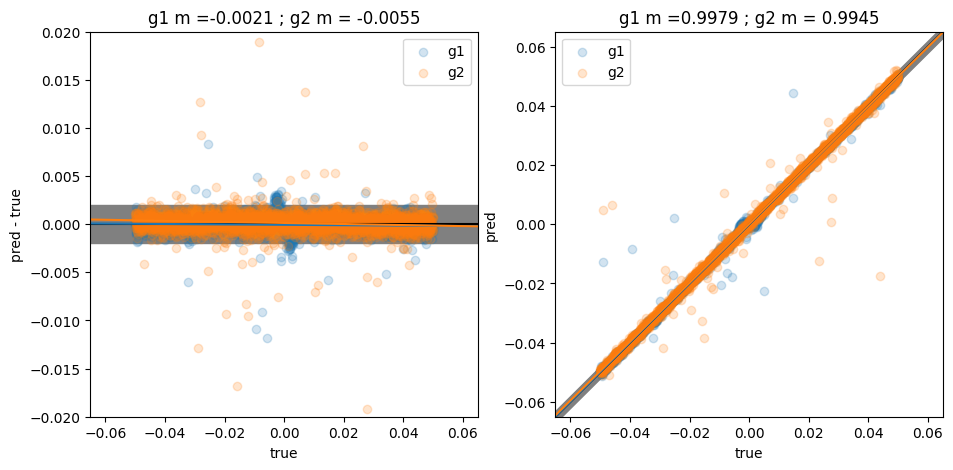

In [28]:
# cut external values to avoid errors in g1
preds = preds[np.sqrt(truth[:,0]**2)<0.05]
truth = truth[np.sqrt(truth[:,0]**2)<0.05]
preds = preds[np.sqrt(truth[:,1]**2)<0.05]
truth = truth[np.sqrt(truth[:,1]**2)<0.05]

poly_g1 = np.polyfit(truth[:,0],preds[:,0] - truth[:,0],1)
poly_g2 = np.polyfit(truth[:,1],preds[:,1] - truth[:,1],1)

plt.figure(figsize=(11,5))

#
plt.subplot(121)

plt.axhline(0, color='k')
plt.axhspan(-0.002,0.002, color='gray');

t = np.linspace(-0.065,0.065)
plt.plot(t, poly_g1[1]+poly_g1[0]*t, color='C0')
plt.plot(t, poly_g2[1]+poly_g2[0]*t, color='C1')

plt.scatter(truth[:,0], preds[:,0] - truth[:,0], alpha=0.2, label='g1',color='C0')
plt.scatter(truth[:,1], preds[:,1] - truth[:,1], alpha=0.2, label='g2',color='C1')
plt.xlabel('true')
plt.ylabel('pred - true')

plt.legend();
plt.title('g1 m =%0.4f ; g2 m = %0.4f'%(poly_g1[0], poly_g2[0]))
plt.ylim(-0.02,0.02)
plt.xlim(-0.065,0.065)

#
plt.subplot(122)

t = np.linspace(-0.065,0.065)
plt.plot(t,t, color='k')
plt.fill_between(t,t-0.002,t+0.002, color='gray')
plt.plot(t, poly_g1[1]+(poly_g1[0]+1)*t, color='C0')
plt.plot(t, poly_g2[1]+(poly_g2[0]+1)*t, color='C1')

plt.scatter(truth[:,0], preds[:,0], alpha=0.2, label='g1',color='C0')
plt.scatter(truth[:,1], preds[:,1], alpha=0.2, label='g2',color='C1')
plt.xlabel('true')
plt.ylabel('pred')

plt.legend();
plt.title('g1 m =%0.4f ; g2 m = %0.4f'%(poly_g1[0]+1, poly_g2[0]+1))
plt.ylim(-0.065,0.065)
plt.xlim(-0.065,0.065)

plt.savefig(PLOTS_dir+case+'_predtrue.png')